In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import Image, display_png
from sklearn.metrics import confusion_matrix

# digitsデータを使うためにimportする
from torchvision.datasets import CIFAR10
import torchvision

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

In [ ]:
trainset = CIFAR10(root='./data',
                     train=True,
                     download=True,
                transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize(224),
                    torchvision.transforms.ToTensor()
                ]))

testset = CIFAR10(root='./data',
                    train=False,
                    download=True,
                  transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize(224),
                    torchvision.transforms.ToTensor()
                ]))

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
test_loader = DataLoader(testset, batch_size=16, shuffle=True)

In [ ]:
len(testset)

## そもそもCIFAR10とは？
- [80 million tiny image](http://groups.csail.mit.edu/vision/TinyImages/)から抽出したラベル付けしたデータセット
- クラスラベル：'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'の10クラス
- trainsetは50,000枚 / testsetは10,000枚

※ちなみにラベル付けしたのはAlexNetを設計した[Alex Krizhevskyさん](https://www.cs.toronto.edu/~kriz/cifar.html)。

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## PyTorchで学習済みモデルを使う方法は以下の通り
- step1: modelsからネットワークを指定
- step2: 入力の大きさと出力の大きさを調整<br>
※point：学習済みのパラメーターの更新を行わない

## step1: modelsからネットワークを指定

In [ ]:
model_ft = models.resnet18(pretrained=True)

パラメーターを学習させないように、require_grad = Falseとする

In [ ]:
for param in model_ft.parameters():
    param.require_grad = False

## step2: 入力の大きさと出力の大きさを調整

In [ ]:
# 最後の一層だけ書き換えて、最後の一層だけ学習させる
# 元々は(fc): Linear(in_features=512, out_features=1000, bias=True) なので、out_featuresが1000である
# 今回のCIFAR-10はout_featuresが10なので、out_features=len(classes)と設定している
model_ft.fc = nn.Linear(in_features=512, out_features=len(classes), bias=True)

In [ ]:
model_ft = model_ft.to(device)

In [ ]:
# 損失関数の定義
loss_func = nn.CrossEntropyLoss()
print(loss_func)

In [ ]:
# 最適化関数の定義
optimizer = optim.SGD(model_ft.parameters(), lr=0.001)

In [ ]:
# 10エポック終了するまで時間がかかるので、途中で終了してください。
# 次セルを実行することで、10エポック終了後のアウトプットイメージを確認することができます。

train_loss_track = []
test_loss_track = []

# エポック数は適宜変更してください
epoc_num = 10

for epoc in range(epoc_num): 
    running_loss = 0
    running_test_loss = 0
    
    # 学習モード
    model_ft.train()
    for step, (xx, yy)  in enumerate(train_loader):
        
        # device = "cuda"の場合、GPUにデータを転送する
        xx = xx.to(device)
        yy = yy.to(device)
        
        # 最後に計算した各パラメーターの勾配を初期化する
        optimizer.zero_grad()
        
        # フォワード計算を行う
        y_pred = model_ft(xx)
        
        # 誤差関数を使ってギャップの計測
        loss = loss_func(y_pred, yy)
        
        # 誤差逆伝播法を使って自動微分
        loss.backward()
        
        # パラメーターを更新
        optimizer.step()
        
        # 学習データを使って損失を計算
        running_loss += loss.item()
        
        #途中経過出力
        if step % 100 == 0:
            print('[{:d}, {:5d}] loss: {}'
                    .format(epoc + 1, step + 1, running_loss / 100))
            running_loss = 0.0
        
    # エポックが終了したら平均損失を計算
    train_loss_track.append(running_loss/step)
    
    
    #評価（evaluation）モード
    model_ft.eval()
    
    with torch.no_grad():
        for step, (xx_test, yy_test)  in enumerate(test_loader):
            
            # device = "cuda"の場合、GPUにデータを転送する
            xx_test = xx_test.to(device)
            yy_test = yy_test.to(device)

            # 予測値を計算
            y_pred = model_ft(xx_test)

            # 誤差関数を使ってギャップの計測
            test_loss = loss_func(y_pred, yy_test)

            # テストデータを使って損失を計算
            running_test_loss += test_loss.item()
            
         # 誤差をトラッキング
        test_loss_track.append(running_test_loss / (step + 1))

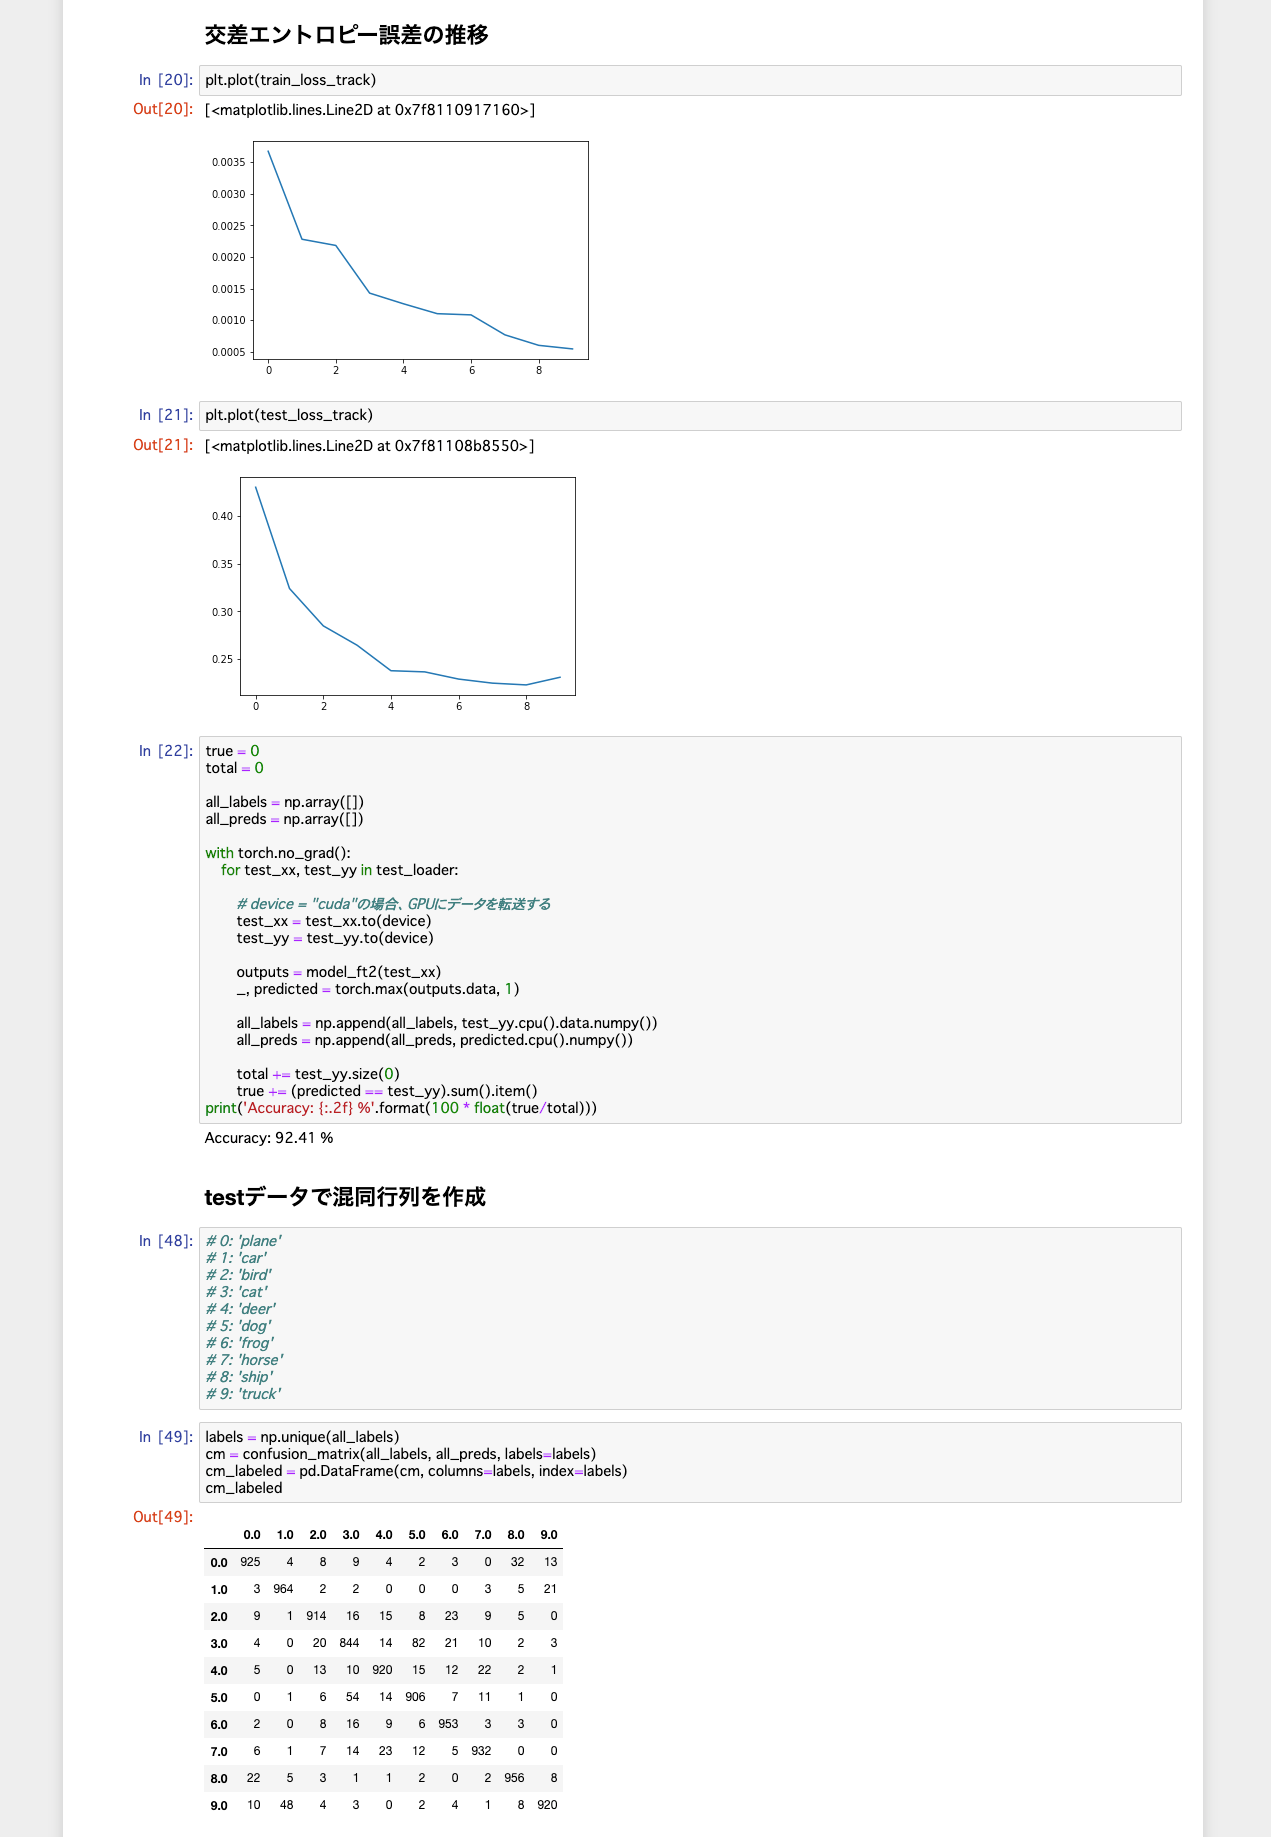

In [2]:
display_png(Image("img/transfer_learning_output.png"))

## 交差エントロピー誤差の推移

In [ ]:
plt.plot(train_loss_track)

In [ ]:
plt.plot(test_loss_track)

In [ ]:
true = 0
total = 0

all_labels = np.array([])
all_preds = np.array([])

with torch.no_grad():
    for test_xx, test_yy in test_loader:
        
        # device = "cuda"の場合、GPUにデータを転送する
        test_xx = test_xx.to(device)
        test_yy = test_yy.to(device)

        outputs = model_ft(test_xx)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels = np.append(all_labels, test_yy.cpu().data.numpy())
        all_preds = np.append(all_preds, predicted.cpu().numpy())
        
        total += test_yy.size(0)
        true += (predicted == test_yy).sum().item()
print('Accuracy: {:.2f} %'.format(100 * float(true/total)))

## testデータで混同行列を作成

In [ ]:
# 0: 'plane'
# 1: 'car'
# 2: 'bird'
# 3: 'cat'
# 4: 'deer'
# 5: 'dog'
# 6: 'frog'
# 7: 'horse'
# 8: 'ship'
# 9: 'truck'

In [ ]:
labels = np.unique(all_labels)
cm = confusion_matrix(all_labels, all_preds, labels=labels)
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
cm_labeled

## 宿題
---
Day2_HW_transfer_learningを利用して、ResNet以外のネットワークで転移学習を実装してください。<br>
実装環境はCollaboratory（ https://colab.research.google.com/notebooks/welcome.ipynb?hl=ja ）を利用してください。<br>